In [2]:
cd ..


/home/mushahid/Desktop/project/cpenprojec/UnsupGenModbyMPS


## Imports

In [3]:
%load_ext autoreload
from pennylane import numpy as pnp
from tqdm import tqdm
from MPScumulant import MPS_c
from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import pennylane as qml
import numpy as np
import jax.numpy as jnp
import optax
import jax
import metrics
import mps_circuit_helpers as helpers
import mps_circuit
import metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initial Weights: Either Randomly Assigned With No Restrictions or Weights Near Unitary

In [4]:
weights_random = jnp.array(pnp.random.normal(size=(88, 15), requires_grad=True))

weights_near_unitary = jnp.array(pnp.random.uniform(low = -0.01, high=0.01, size=(88, 15), requires_grad=True))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Circuit

(<Figure size 8200x1300 with 1 Axes>, <Axes: >)

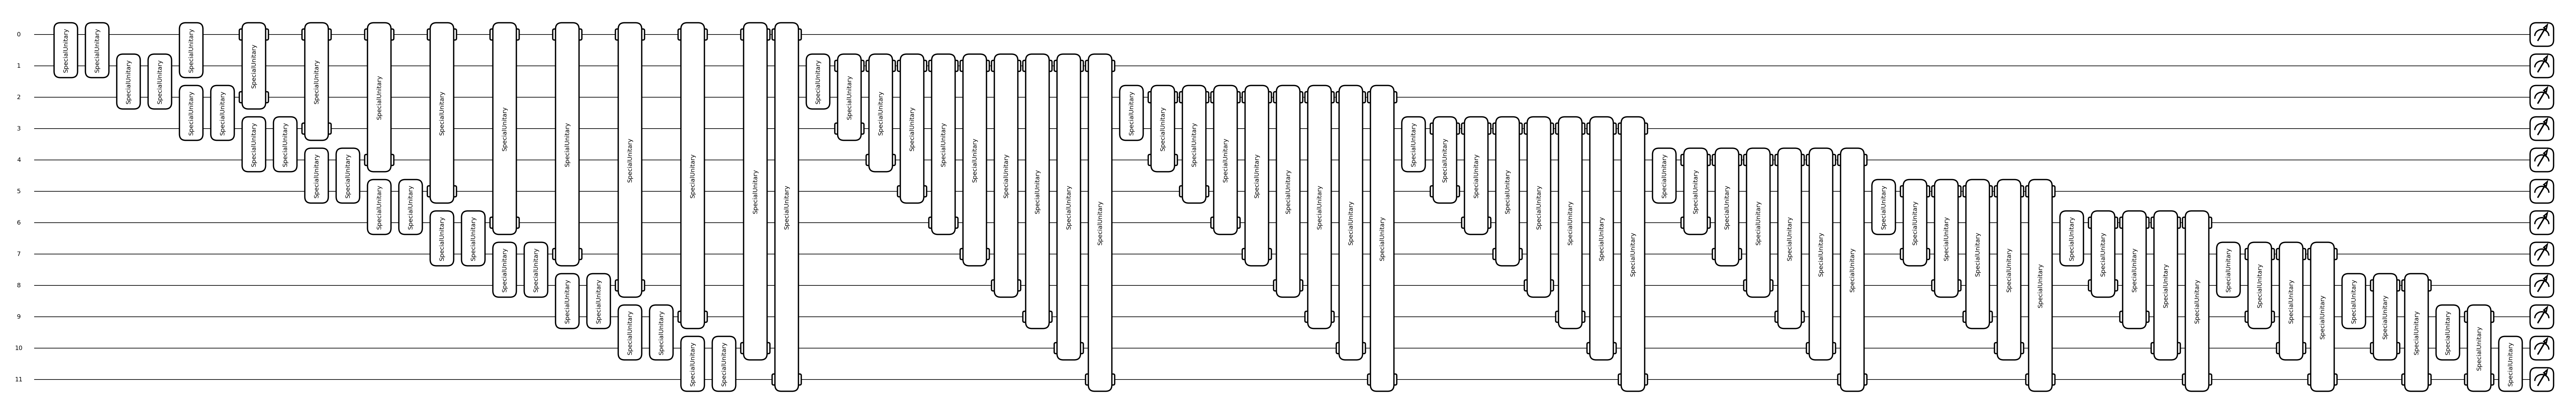

In [5]:
def random_initialized_circuit(weights, shots = None, wires = 12):
    dev = qml.device("default.qubit", wires=wires, shots=shots)
    
    @qml.qnode(dev, interface="jax")
    def qnode():
        for i in range(11):
            qml.SpecialUnitary(weights[i], wires=[i, i + 1])
            qml.SpecialUnitary(weights[i + 11], wires=[i, i  + 1])
        
        for x in range(wires - 1):
            for j in range(x + 1, wires):
                qml.SpecialUnitary(weights[i], wires=[x, j])
                i += 1

        if shots is not None:
            return qml.sample()
        
        return qml.probs(wires=list(range(wires)))
    
    return qnode

qml.drawer.draw_mpl(random_initialized_circuit(weights_random))()


## Training of the Model

In [6]:
N_ITS = 15000
LEARNING_RATE = 0.01

opt_exc = optax.adam(LEARNING_RATE)
opt_state = opt_exc.init(weights_random)

loss_track = []
data = np.load('BStest/b_s_4_3.npy')

data_states = data.reshape(-1, 12).astype(np.int8)

@jax.jit
def loss(weights):
    probs = random_initialized_circuit(weights)()
    filter_qc_probs = metrics.filter_probs(probs, data_states)
    return metrics.kl_divergence_synergy_paper(22, filter_qc_probs)


for it in tqdm(range(N_ITS)):
    grads = jax.grad(loss)(weights_random)
    updates, opt_state = opt_exc.update(grads, opt_state)
    weights_random = optax.apply_updates(weights_random, updates)
    loss_track.append(loss(weights_random))

100%|██████████| 15000/15000 [21:36<00:00, 11.57it/s]


## Plot KL - Divergence

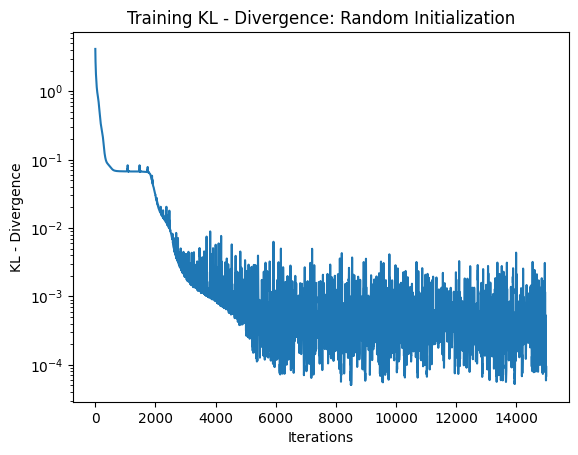

In [7]:
plt.plot(loss_track)
plt.title('Training KL - Divergence: Random Initialization')
plt.xlabel('Iterations')
plt.ylabel('KL - Divergence')
plt.yscale('log')

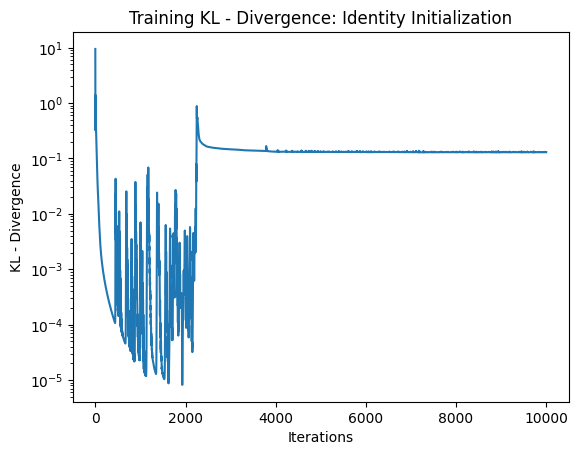

In [15]:
plt.plot(loss_track)
plt.title('Training KL - Divergence: Identity Initialization')
plt.xlabel('Iterations')
plt.ylabel('KL - Divergence')
plt.yscale('log')

In [8]:
data = np.load('BStest/b_s_4_3.npy')

data_states = data.reshape(-1, 12).astype(np.int8)

%autoreload
m = MPS_c(12, max_bond_dim=300)
m.loadMPS('BS_4_3-300-MPS')

# check the properties of the matrices in the MPS
for i in range(len(m.matrices)):
    tn_core = m.matrices[i]
    
m_pad = helpers.pad_mps(m)

# check the properties of the matrices in the paddded MPS
for i in range(len(m_pad.matrices)):
    tn_core = m_pad.matrices[i]
    
m_pad.left_cano()
unitary_list = []
tn_cores = m_pad.matrices
for site_idx in range(len(tn_cores)):
    tn_core = tn_cores[site_idx]
    # this step assumes that the core tensor is a left isometry
    u_mat = helpers.isometry_to_unitary(tn_core.reshape(-1, tn_core.shape[2]))
    unitary_list.append(u_mat)
    
truncated_unitary_list = unitary_list[1:]
n_wires = len(truncated_unitary_list) + 1
dev = qml.device("default.qubit", wires=n_wires, shots=None)

wires_connected = []

def helper():
    total_num_weights = 0
    for wire in range(n_wires-1, -1, -1):
        n_qubits = int(np.log2(unitary_list[wire].shape[0]))
        u_wires = [wire] + list(range(wire-1, wire-n_qubits, -1))
        u_wires.reverse()
        wires_connected.append(u_wires)
        
    wires_connected_len_2 = set()
    for w in wires_connected:
        for i in range(len(w) - 1):
            for j in range(i, len(w)):
                wires_connected_len_2.add((w[i], w[j]))
                
    for x in range(11):
        for j in range(x + 1, 12):
            if (x, j) not in wires_connected_len_2 and (j, x) not in wires_connected_len_2:
                total_num_weights += 1
                
    return total_num_weights 

total_num_weights = helper()
             
@qml.qnode(dev, interface="jax")
def mps_circ_extended(weights):
    for wire in range(n_wires-1, -1, -1):
        unitary = unitary_list[wire]
        n_qubits = int(np.log2(unitary.shape[0]))
        u_wires = [wire] + list(range(wire-1, wire-n_qubits, -1))
        u_wires.reverse()
        qml.QubitUnitary(unitary, wires=u_wires)
        wires_connected.append(u_wires)

    wires_connected_len_2 = set()
    for w in wires_connected:
        for i in range(len(w) - 1):
            for j in range(i, len(w)):
                wires_connected_len_2.add((w[i], w[j]))
                
    for x in range(11):
        for j in range(x + 1, 12):
            if (x, j) not in wires_connected_len_2 and (j, x) not in wires_connected_len_2:
                qml.SpecialUnitary(weights[i], wires=[x, j])
                
    # return qml.sample()
    return qml.probs(wires=range(n_wires))


idx, shape of the padded tensor, updated bond dimension
i = 1, (2, 2, 4), 2
i = 2, (4, 2, 8), 4
i = 3, (8, 2, 8), 8
i = 4, (8, 2, 8), 8
i = 5, (8, 2, 8), 8
i = 6, (8, 2, 8), 8
i = 7, (8, 2, 8), 8
i = 8, (8, 2, 8), 8
i = 9, (8, 2, 4), 8
i = 10, (4, 2, 2), 4
bond: 0
bond: 1
bond: 2
bond: 3
bond: 4
bond: 5
bond: 6
bond: 7
bond: 8
bond: 9
bond: 10


In [10]:
weights_random = jnp.array(pnp.random.normal(size=(88, 15), requires_grad=True))

# weights_near_unitary = jnp.array(pnp.random.uniform(low = -0.01, high=0.01, size=(88, 15), requires_grad=True))

N_ITS = 15000
LEARNING_RATE = 0.01

opt_exc = optax.adam(LEARNING_RATE)
opt_state = opt_exc.init(weights_random)
loss_track = []

@jax.jit
def loss(weights):
    probs = mps_circ_extended(weights)
    filter_qc_probs = metrics.filter_probs(probs, data_states)
    return metrics.kl_divergence_synergy_paper(22, filter_qc_probs)

for it in tqdm(range(N_ITS)):
    grads = jax.grad(loss)(weights_random)
    updates, opt_state = opt_exc.update(grads, opt_state)
    weights_random = optax.apply_updates(weights_random, updates)
    loss_track.append(loss(weights_random))

100%|██████████| 15000/15000 [08:57<00:00, 27.90it/s]


In [36]:
# samples = np.zeros((22, 4, 3), dtype=np.int8)
# for i in range(samples.shape[0]):
#     samples[i] = m.generate_sample().reshape(4, 3)
    
# samples.shape
samples = mps_circ_extended(weights_random)
# %autoreload
# metrics.plot_top_samples_synergy(samples)

Frequency : 1
Frequency : 26
Frequency : 22
Frequency : 20
Frequency : 20
Frequency : 19
Frequency : 19
Frequency : 19
Frequency : 18
Frequency : 18
Frequency : 17
Frequency : 17
Frequency : 17
Frequency : 16
Frequency : 16
Frequency : 16
Frequency : 16
Frequency : 15
Frequency : 15
Frequency : 15
Frequency : 15
Frequency : 15


(<Figure size 1800x1500 with 30 Axes>, <Axes: >)

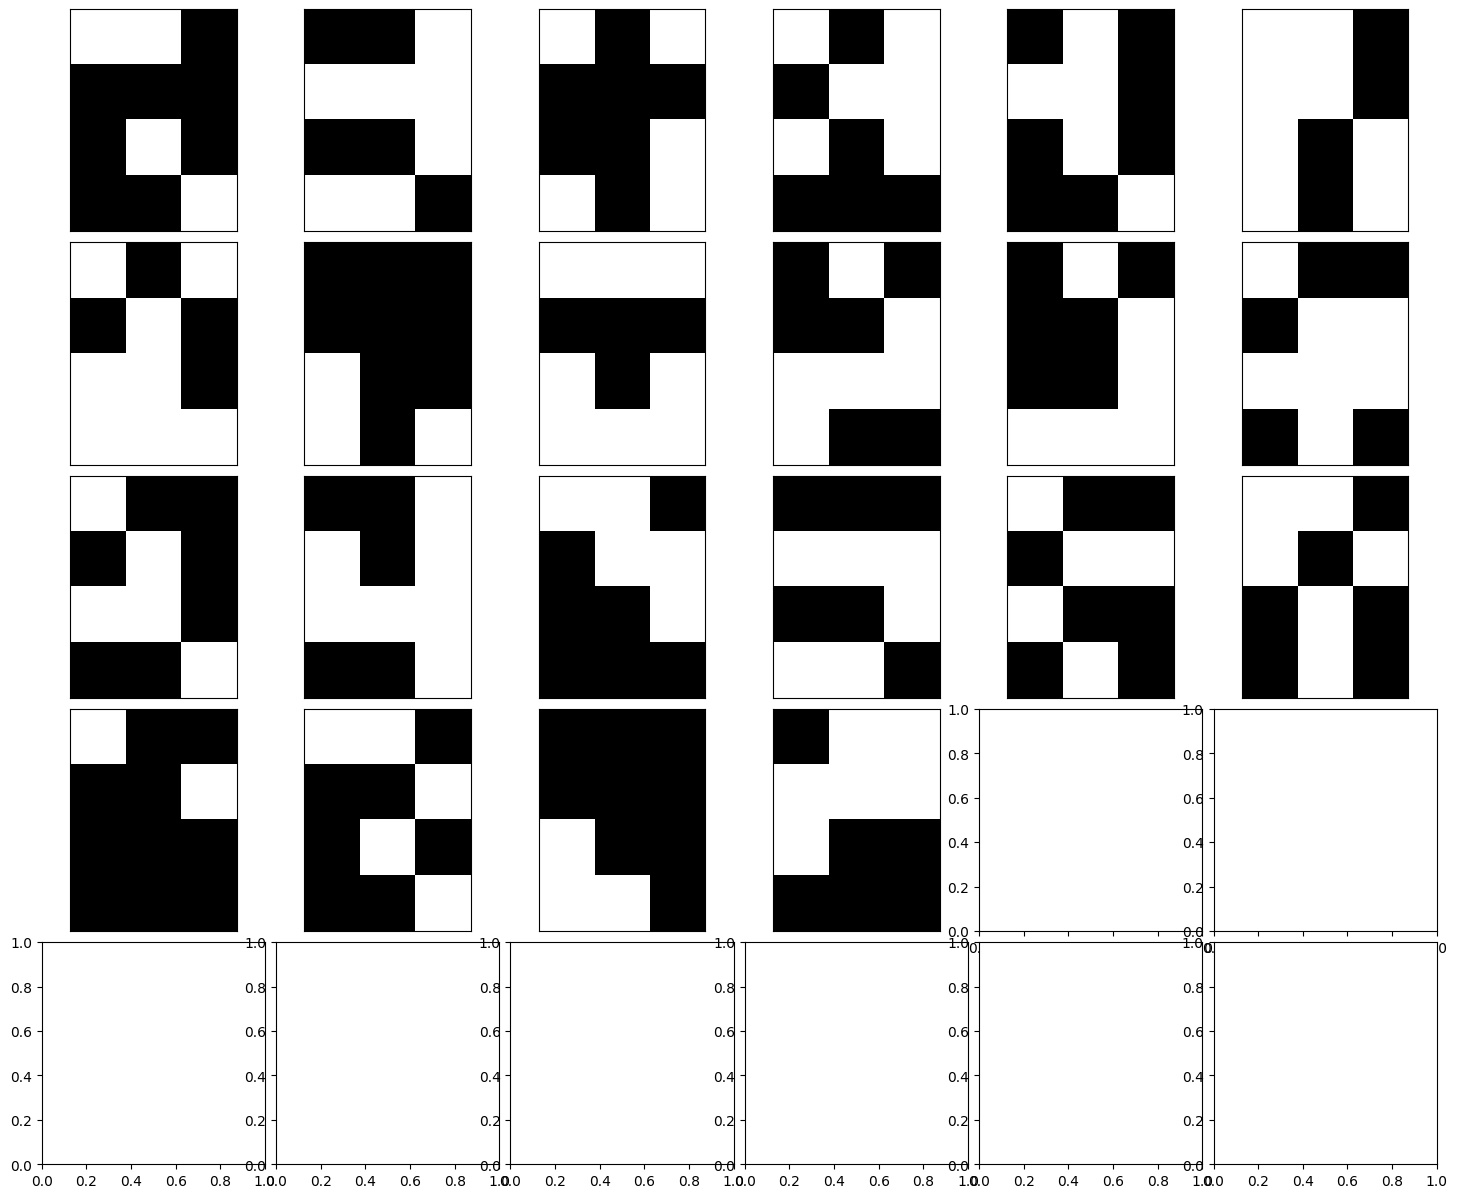

In [37]:
%autoreload
metrics.plot_top_samples_synergy(samples)

In [22]:
mps_probs_states = m.Give_probab(data_states)
metrics.kl_divergence_synergy_paper(22, mps_probs_states)

Array(4.4408921e-16, dtype=float64)

In [21]:
data_states.shape

(22, 12)

In [34]:
cd ..

/home/mushahid/Desktop/project/cpenprojec/UnsupGenModbyMPS


In [23]:
%autoreload
mps_unitaries = helpers.get_mps_unitaries(m)
circ = mps_circuit.mps_unitaries_to_circuit(mps_unitaries)

padding the mps core tensors
idx, shape of the padded tensor, updated bond dimension
i = 1, (2, 2, 4), 2
i = 2, (4, 2, 8), 4
i = 3, (8, 2, 8), 8
i = 4, (8, 2, 8), 8
i = 5, (8, 2, 8), 8
i = 6, (8, 2, 8), 8
i = 7, (8, 2, 8), 8
i = 8, (8, 2, 8), 8
i = 9, (8, 2, 4), 8
i = 10, (4, 2, 2), 4
left canonicalizing the padded MPS
bond: 0
bond: 1
bond: 2
bond: 3
bond: 4
bond: 5
bond: 6
bond: 7
bond: 8
bond: 9
bond: 10


In [24]:
qc_probs = circ()
filter_qc_probs = metrics.filter_probs(qc_probs, data_states)
metrics.kl_divergence_synergy_paper(22, filter_qc_probs)

Array(4.4408921e-16, dtype=float64)

In [33]:
data_states

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1],
       [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
       [0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1],
       [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
       [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1],
       [1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int